## Define a Self-Organising Map Class

In [182]:
import numpy as np
import math as m
from matplotlib import pyplot as plt
from numpy.linalg import norm
from IPython.display import clear_output

        
class SelfOrganisingMap:
    
    def __init__(self, dimX, dimY, dimW, sigma=5, eta=5):
        
        self.grid = np.random.rand(dimX, dimY, dimW)
        self.gauss = np.vectorize(np.vectorize(lambda x,mu,sigma: 1. / m.sqrt(2. * sigma * m.pi) * m.exp(-(x-mu) ** 2. / (2.*sigma))))
        self.sigma = sigma
        self.eta = eta
        
    # returns the row / column indicies of the best matching unit for a given datapoint
    def getBMU(self, x):
        
        idx = np.mean(np.abs(self.grid-x),2).argmin()
        return idx / self.grid.shape[1], idx % self.grid.shape[1]
    
    # returns an array representing the distance of each cell from the given row/col
    def dist(self, row, col):
        
        rows = abs(np.arange(self.grid.shape[0]*self.grid.shape[1]).reshape([self.grid.shape[0],self.grid.shape[1]]) / self.grid.shape[1] - row)
        cols = abs(np.arange(self.grid.shape[0]*self.grid.shape[1]).reshape([self.grid.shape[0],self.grid.shape[1]]) % self.grid.shape[1] - col)

        return np.sqrt(np.power(rows,2) + np.power(cols,2))

    def update(self,x):
        
        # get the best matching unit
        r,c = self.getBMU(x)
        
        # now see how much we need to correct all the units around the BMU
        alpha = self.gauss(self.dist(r,c),0,self.sigma)
        
        # add a new axis onto alpha so we can braodcast it onto all layers of the grid
        alpha = alpha[:,:, np.newaxis]

        # now calculate exactly how much to add to each of the neighbouring units
        delta = alpha * (x - self.grid)
        
        # lastly update the grid
        self.grid += (delta * self.eta)
        

## Test the Update Process

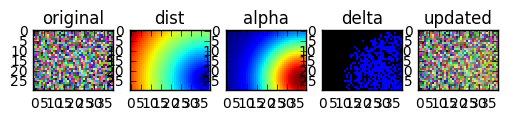

In [2]:
som = SelfOrganisingMap(30,40,3,200,10)

x = [0.9, 0.95, 0.1]

r,c = som.getBMU(x)

plt.subplot(1, 5, 1)
plt.title("original")
plt.imshow(som.grid,interpolation='none')

plt.subplot(1, 5, 2)
plt.title("dist")
plt.imshow(som.dist(r,c),interpolation='none')

plt.subplot(1, 5, 3)
plt.title("alpha")
alpha = som.gauss(som.dist(r,c),0,som.sigma)
plt.imshow(alpha,interpolation='none')

plt.subplot(1, 5, 4)
plt.title("delta")
alpha = alpha[:,:, np.newaxis]
delta = alpha * (x - som.grid)
plt.imshow(delta,interpolation='none')

plt.subplot(1, 5, 5)
plt.title("updated")
som.grid += delta * som.eta
plt.imshow(som.grid,interpolation='none')

plt.show()

## Test a Batch Update

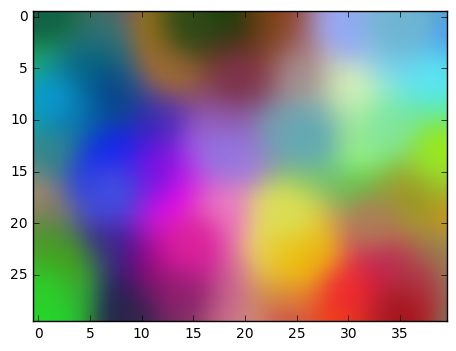

In [43]:
som = SelfOrganisingMap(30,40,3,5,5)

batch = [np.random.rand(3) for _ in range(400)]

for x in batch:
    som.update(x)

plt.imshow(som.grid)
plt.show()

## Import the Photos from their Folder

In [181]:
import os
import scipy.misc as misc

class Photo:
    def __init__(self, filepath):
        self.filepath = filepath
        img = misc.imread(filePath)
        self.coords = (0,0)
        self.dims = img.size
        self.aspectRatio = img.size[0] / img.size[1] # w / h
        self.val = misc.imread(filePath).mean(axis=(0,1))[:3]

class Collage:
    pass
        
directory = os.path.join(os.getcwd(),'thumbs')

# We'll populate a dictionary keyed on the image's filename for it's mean RGB val
collage = []

for f in os.listdir(directory):
    filePath = os.path.join(directory, f)
    collage.append(Photo(filePath))

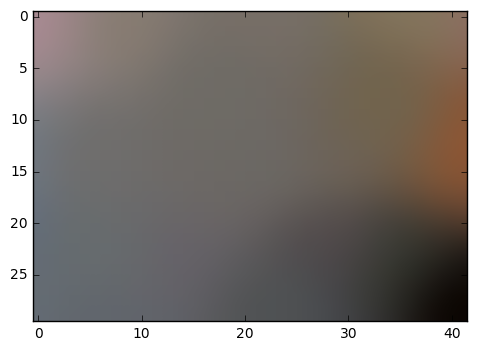

In [810]:
som = SelfOrganisingMap(30,42,3,20,10)

for photo in collage:
    som.update(photo.val.round() / 255)

plt.imshow(som.grid)
plt.show()

[[ 4.98586494  4.9770078   0.          0.        ]] [[[ 49.98586494]
  [ 49.9770078 ]
  [ 40.0229922 ]
  [ 40.01413506]]]


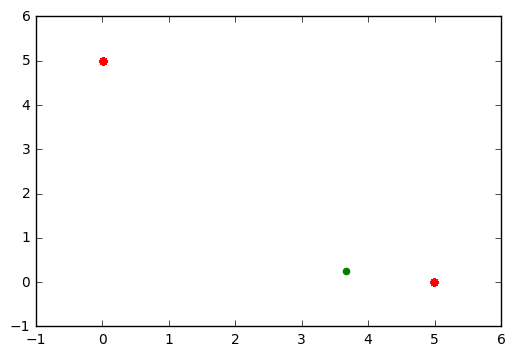

[[ 4.99  0.01]]


In [800]:
N = 1
k = 10
dimX = 5; dimY = 5;
p = np.dot(np.random.rand(N,2),[[dimX,0],[0,dimY]])

# Before
plt.scatter(p[:,0], p[:,1],color='green')

gauss = np.vectorize(np.vectorize(lambda x,mu,sigma: 1. / m.sqrt(2. * sigma * m.pi) * m.exp(-(x-mu) ** 2. / (2.*sigma))))

# this let's me remove references from the point to the same point in the distance matrix
idx = ~np.identity(p.shape[0]*5,dtype=bool)[:,:,np.newaxis]
idx = np.concatenate((idx,idx),axis=2)

for i in range(100):
    p += np.random.rand(p.shape[0], p.shape[1]) % 0.01

    points = np.concatenate((p,p * [1,-1], p * [-1,1], ((p - [dimX,0]) * [-1,1]) + [dimX,0], ((p - [0,dimY]) * [1,-1]) + [0,dimY]),axis=0) 

    dist = points[:,:,np.newaxis] - points.T.reshape([1,2,points.shape[0]])
    dist = dist.transpose(0,2,1)
    dist = dist[idx].reshape(dist.shape[0],dist.shape[0]-1,2)

    # here we scale each distance by the dimensions of the photo - but later

    norm = np.linalg.norm(dist,axis=2)    
    ids = np.argsort(norm)

    # trim these matrices to include only the k nearest neighbours to speed things up (hopefully)
    norm = norm[np.arange(norm.shape[0]/5)[:,np.newaxis],ids[:N,:k]]
    dist = dist[np.arange(dist.shape[0]/5)[:,np.newaxis],ids[:N,:k],:]
    
    vect = dist / norm[:,:,np.newaxis]
    mag = np.maximum(50-norm,0)[:,:,np.newaxis] #gauss(norm,0,1)[:,:,np.newaxis]
    
    p += np.sum(vect * mag,axis=1)
    p = np.clip(p,[0.01,0.01],[dimX-0.01,dimY-0.01])
    plt.scatter(p[:,0], p[:,1],color='red')
    
print np.maximum(5-norm,0), mag
    
# After
plt.scatter(p[:,0], p[:,1],color='red')
plt.show()

print p

In [624]:
from IPython.display import clear_output
        
def Equalise(p,dimX,dimY,k=p.shape[0],iterations=1000,margin=0.01):
    
    gauss = np.vectorize(np.vectorize(lambda x,mu,sigma: 1. / m.sqrt(2. * sigma * m.pi) * m.exp(-(x-mu) ** 2. / (2.*sigma))))

    # this let's me remove references from the point to the same point in the distance matrix
    idx = ~np.identity(p.shape[0],dtype=bool)[:,:,np.newaxis]
    idx = np.concatenate((idx,idx),axis=2)

    borders = np.zeros([p.shape[0],4,2])    

    for i in range(iterations):
        p += np.random.rand(p.shape[0], p.shape[1]) % 0.01
            
        otherPoints = p[:,:,np.newaxis] - p.T.reshape([1,2,p.shape[0]])
        otherPoints = otherPoints.transpose(0,2,1)
        otherPoints = otherPoints[idx].reshape(p.shape[0],p.shape[0]-1,2)

        # if I mirror image the points along the borders then they'll even out perfectly
        
        borders[:,0,0] = p[:,0] / 4
        borders[:,1,0] = (p[:,0] - dimX) / 4
        borders[:,2,1] = p[:,1] / 4
        borders[:,3,1] = (p[:,1] - dimY) / 4

        dist = np.concatenate((otherPoints,borders),axis=1)
        norm = np.linalg.norm(dist,axis=2)

        # consider only the k nearest neighbours to save some computation time
        ids = np.argsort(norm)
        norm = norm[np.arange(norm.shape[0])[:,np.newaxis],ids[:,:k]]
        dist = dist[np.arange(dist.shape[0])[:,np.newaxis],ids[:,:k],:]
        
        vect = dist / norm[:,:,np.newaxis]
        mag = gauss(norm,0,0.5)[:,:,np.newaxis]

        p += np.sum(vect * mag,axis=1)
        p = np.clip(p,[0.01,0.01],[dimX-0.01,dimY-0.01])

    clear_output()
    return p

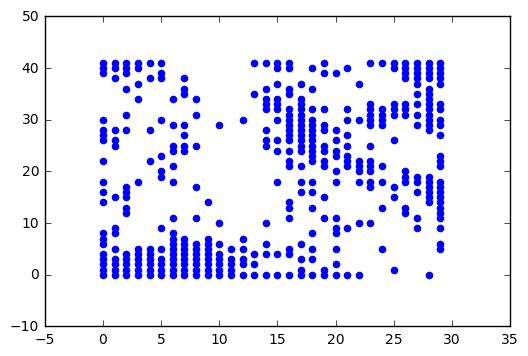

In [815]:
import copy

BMUs = []
somCopy = copy.deepcopy(som)

for photo in collage:
    BMU = somCopy.getBMU(photo.val.round() / 255)
    BMUs.append(BMU)
    somCopy.grid[BMU] = [100000, 100000, 100000] 

BMUarr = np.array(BMUs).astype(float)

plt.scatter(BMUarr[:,0], BMUarr[:,1],color='blue')
plt.show()

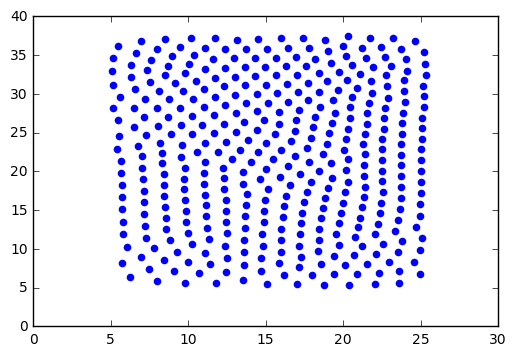

In [626]:
BMUarr = Equalise(BMUarr,som.grid.shape[0],som.grid.shape[1],10,500)

plt.scatter(BMUarr[:,0], BMUarr[:,1],color='blue')
plt.show()

## Now take each of the photos and arrange them on the SOM

In [ ]:
for x in photos.values():
    som.update(x/(x.max()))

## And render them to an image

(80, 50)


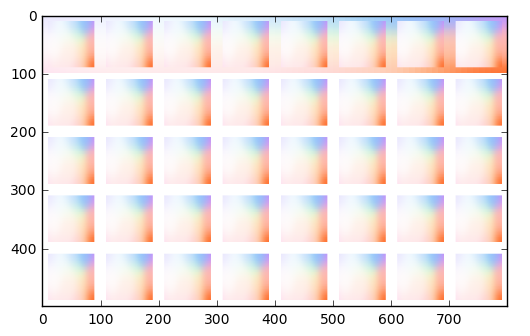

In [24]:
import PIL.Image
import PIL.ImageDraw

canvas = PIL.Image.new("RGB", (800, 500), "white")

img = PIL.Image.open('pretty_colours_2.png')

print img.size

canvas.paste(img, (0, 0))

canvas.paste(img.resize((800,100),PIL.Image.NEAREST), (0, 0))

for r in range(8):
    for c in range(5):
        canvas.paste(img.resize((80,80),PIL.Image.NEAREST), (r*100+10, c*100+10))

plt.imshow(canvas)
plt.show()

Now how do I want this to go? Definitely I want to keep the entire image, having a grid just makes the image seem really artificial.

So I probably need to arrange the photos such that their sum distance from their BMU is minimised. How to do that though is a mystery to me.

How about I just arrange the images in a row then scale them all to the average height of all the images in the row, then just scale the row to fit the width of the canvas. - wont work

ok! so I do it gradient descent style, kind of. I'll say place every picture at it's nearest BMU. 
